In [1]:
# import the libraries as shown below

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

# Here Resnet50 model is implemented , please try with Resnet50V2 too.

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet50 import ResNet50

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
        
train_path = './Datasets/GreenHot(Dataset)/Training/'

In [3]:
# Import the Resnet50 or Resnet50 V2 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

Rsnetv2 = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [4]:
# don't train existing weights
for layer in Rsnetv2.layers:
    layer.trainable = False

In [5]:
# useful for getting number of output classes
folders = glob('./Datasets/GreenHot(Dataset)/Training/*')

In [6]:
len(folders)

2

In [7]:
# our layers - you can add more if you want
x = Flatten()(Rsnetv2.output)

In [8]:
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=Rsnetv2.input, outputs=prediction)

In [9]:
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='Adamax', #Adamax , RMSprop , Adagrad
  metrics=['accuracy','AUC','Precision','Recall'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [12]:
#Total BFlops
from model_profiler import model_profiler

Batch_size = 32
profile = model_profiler(model, Batch_size)

print(profile)

| Model Profile                    | Value         | Unit    |
|----------------------------------|---------------|---------|
| Selected GPUs                    | None Detected | GPU IDs |
| No. of FLOPs                     | 0.0696        | BFLOPs  |
| GPU Memory Requirement           | 3.7746        | GB      |
| Model Parameters                 | 23.6652       | Million |
| Memory Required by Model Weights | 90.2754       | MB      |


In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 50

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.5,1.0],
        fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('./Datasets/GreenHot(Dataset)/Training/',
                                                 target_size = (224, 224),
                                                 batch_size = 50,
                                                 class_mode = 'binary')

test_set = validation_datagen.flow_from_directory('./Datasets/GreenHot(Dataset)/Testing/',
                                            target_size = (224, 224),
                                            batch_size = 50,
                                            class_mode = 'binary')

Found 1244 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


In [24]:
len(training_set)

25

In [25]:
training_set.class_indices

{'Fire': 0, 'No_Fire': 1}

In [26]:
imgs ,labels = next(training_set)

In [27]:
from matplotlib import pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

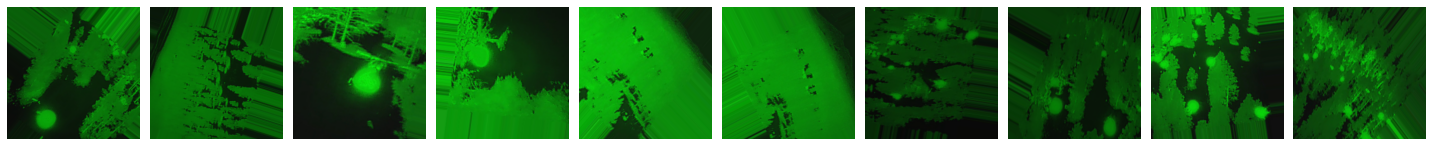

[0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0.
 1. 0.]


In [28]:
plotImages(imgs)
print(labels)

In [30]:
#Add checkpoints 
from keras.callbacks import ModelCheckpoint
#filepath='saved_models/models.h5'
filepath="./FirevsNonFire_Resnet50v2_GH_transfer_learning_model_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [50]:
history = model.fit(training_set,
          steps_per_epoch= 1000 // batch_size,
          epochs=10, 
          validation_data=test_set,
          validation_steps= 200 // batch_size,
          callbacks=callbacks_list)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 2.0593 - accuracy: 0.8450 - auc: 0.8863 - precision: 0.8014 - recall: 0.8341
Epoch 00001: val_accuracy improved from 0.47000 to 0.88500, saving model to .\FirevsNonFire_Resnet50v2_GH_transfer_learning_model_weights-improvement-01-0.88.hdf5
20/20 [==============================] - 98s 5s/step - loss: 2.0593 - accuracy: 0.8450 - auc: 0.8863 - precision: 0.8014 - recall: 0.8341 - val_loss: 0.4298 - val_accuracy: 0.8850 - val_auc: 0.9531 - val_precision: 1.0000 - val_recall: 0.7553
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.9396 - auc: 0.9769 - precision: 0.9265 - recall: 0.9310
Epoch 00002: val_accuracy improved from 0.88500 to 0.95500, saving model to .\FirevsNonFire_Resnet50v2_GH_transfer_learning_model_weights-improvement-02-0.95.hdf5
20/20 [==============================] - 96s 5s/step - loss: 0.2754 - accuracy: 0.9396 - auc: 0.9769 - precision: 0.9265 - recall: 0.9310 - v

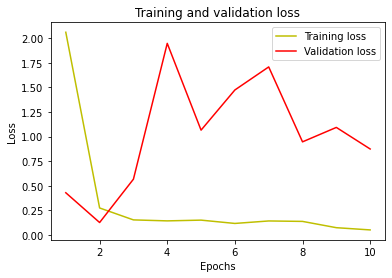

In [51]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

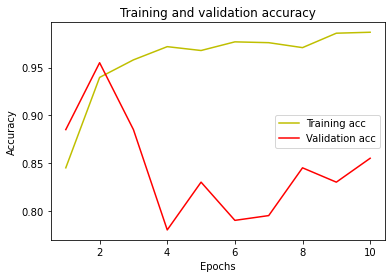

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

-----------------------------------------------------------------------------------------

In [ ]:
from tensorflow import keras

model = keras.models.load_model(' ')

In [ ]:
y_pred = model.predict(test_set) 

In [ ]:
y_pred

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

In [ ]:
misclassified=np.where(test_set!=y_pred)
misclassified

In [ ]:
print("Total Misclassified Samples: ",len(misclassified[0]))

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import os 

image_directory = 'Datasets/Deep_Learning(Data)/New/Fire/'
firecount=0
nofirecount=0
for i in os.listdir(image_directory):
    img = image.load_img(image_directory+'//'+i,target_size=(224,224))
    plt.imshow(img)
    img = image.img_to_array(img)
    x = img.reshape((1,)+ img.shape)
    val = model.predict(x) 
    val = np.argmax(val, axis=1)
    plt.show() 
    if(val == 0 ):
        print("Fire")
        firecount+=1
    else:
        print("No Fire")
        nofirecount+=1
print("Fire Images:",firecount)
print("No Fire Images:",nofirecount)

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import os 

image_directory = 'Datasets/Deep_Learning(Data)/New/No_Fire/'
firecount=0
nofirecount=0
for i in os.listdir(image_directory):
    img = image.load_img(image_directory+'//'+i,target_size=(224,224))
    plt.imshow(img)
    img = image.img_to_array(img)
    x = img.reshape((1,)+ img.shape)
    val = model.predict(x) 
    val = np.argmax(val, axis=1)
    plt.show() 
    if(val == 0 ):
        print("Fire")
        firecount+=1
    else:
        print("No Fire")
        nofirecount+=1
print("Fire Images:",firecount)
print("No Fire Images:",nofirecount)